<a href="https://colab.research.google.com/github/RSinhoroto/UnBFace/blob/master/AFW_Facial_Pose_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-06054216-ded0-a566-7ca4-ded8a958425c)


In [0]:
# download dataset files
!git clone https://github.com/RSinhoroto/AFWDataset.git
%cd AFWDataset
!ls

Cloning into 'AFWDataset'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 233 (delta 0), reused 3 (delta 0), pack-reused 229
Receiving objects: 100% (233/233), 93.77 MiB | 46.52 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/AFWDataset
clr_callback.py  faces.txt	images	   preprocessing.m
eyes.txt	 filenames.txt	poses.txt  README.md


In [0]:
%tensorflow_version 1.x

# import general and image processing libraries
from skimage.io import imread, imshow, show 
from skimage.transform import resize
import matplotlib.pyplot as plt
from math import degrees
import tensorflow as tf
import numpy as np


In [0]:
# import keras modules
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, concatenate
from keras.applications import InceptionV3
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
def plot_training(history, ymin=0, ymax=50):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].plot(history.history['dense_2_mean_absolute_error'], 
                 label='Yaw Train MAE')
    axes[0].plot(history.history['val_dense_2_mean_absolute_error'], 
                 label='Yaw Val MAE')
    axes[0].set_xlabel('Epochs')
    ymax = 2*np.mean(history.history['val_dense_2_mean_absolute_error'][10:])
    axes[0].set_ylim([ymin,ymax])
    axes[0].legend()
    
    axes[1].plot(history.history['dense_4_mean_absolute_error'], 
                 label='Pitch Train MAE')
    axes[1].plot(history.history['val_dense_4_mean_absolute_error'], 
                 label='Pitch Val MAE')
    axes[1].set_xlabel('Epochs')
    ymax = 2*np.mean(history.history['val_dense_4_mean_absolute_error'][10:])
    axes[1].set_ylim([ymin,ymax])
    axes[1].legend()

    axes[2].plot(history.history['dense_6_mean_absolute_error'], 
                 label='Roll Train MAE')
    axes[2].plot(history.history['val_dense_6_mean_absolute_error'], 
                 label='Roll Val MAE')
    axes[2].set_xlabel('Epochs')
    ymax = 2*np.mean(history.history['val_dense_6_mean_absolute_error'][10:])
    axes[2].set_ylim([ymin,ymax])
    axes[2].legend()  

In [0]:
imgs_file = open('filenames.txt','r')
imgs_file_content = imgs_file.read()
filenames = imgs_file_content.split('*')
if filenames[-1] == '':
  filenames = filenames[:-1]     #removes last empty element 
imgs_file.close()

In [0]:
faces_file = open('faces.txt','r')
faces_file_content = faces_file.read()
faces = faces_file_content.split('*')
if faces[-1] == '':
  faces = faces[:-1]     #removes last empty element 
faces_file.close()

In [0]:
poses_file = open('poses.txt','r')
poses_file_content = poses_file.read()
poses = poses_file_content.split('*')
if poses[-1] == '':
  poses = poses[:-1]     #removes last empty element 
poses_file.close()

In [0]:
img_side = 96

afw_face_data = []
afw_data_target = []
for i in range(len(filenames)):
  name = filenames[i]
  face_locations = faces[i][1:-1]
  current_pose = poses[i][1:-1]
  
  if face_locations.find(']['):
    face_locations = face_locations.split('][')
    current_pose = current_pose.split('][')
  
  img = imread('images/' + name, as_gray=False)
  for j in range(len(face_locations)):
    coords = face_locations[j]
    ypr = current_pose[j]
    
    points = coords.split(';')
    x0,y0 = points[0].split(' ')
    x1,y1 = points[1].split(' ')
    x0 = int(round(float(x0)))
    y0 = int(round(float(y0)))
    x1 = int(round(float(x1)))
    y1 = int(round(float(y1)))

    angles = ypr.split(' ')
    afw_data_target.append([float(angles[0]),
                            float(angles[1]), 
                            float(angles[2])])
    
    img_crop = img[y0:y1,x0:x1]
    img_crop = resize(img_crop, (img_side,img_side, 3))  # resize to net input size
    afw_face_data.append(img_crop)

# convert to numpy array
afw_face_data = np.asarray(afw_face_data)

In [0]:
# declare instances of base InceptionV3(GoogLeNet) model
base_model = InceptionV3(weights='imagenet', include_top=False, 
                         pooling='avg', input_shape=(img_side,img_side,3))














87916544/87910968 [==============================] - 3s 0us/step


In [0]:
# add fully connect regression layers
out = base_model.output 

#yaw
yaw = Dense(256, activation='relu')(out) 
yaw = Dense(1, activation='linear')(yaw)

#pitch
pitch = Dense(256, activation='relu')(out) 
pitch = Dense(1, activation='linear')(pitch)

#roll
roll = Dense(256, activation='relu')(out) 
roll = Dense(1, activation='linear')(roll)

model = Model(inputs=[base_model.input],
              outputs=[yaw, pitch, roll])

In [0]:
# configure some hyper parameters
INIT_LR = 5e-3
EPOCHS = 300
BATCH_SIZE = 96

In [0]:
# add checkpoint to stop if training doesn't improve
earlystop = EarlyStopping(monitor='val_loss', patience=50)
callbacks_list = [earlystop]

In [0]:
# compile complete model with optmizer and print summary on screen
optim = SGD(lr=INIT_LR, decay=1e-2/EPOCHS)
model.compile(optimizer=optim,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [0]:
!nvidia-smi

Sun Dec  8 21:18:21 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |    483MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# train model and plot training history
history = model.fit(x=[afw_face_data],
                    y=[np.transpose(afw_data_target)[0],
                       np.transpose(afw_data_target)[1],
                       np.transpose(afw_data_target)[2],], 
                    epochs=EPOCHS,
                    validation_split=0.25,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list)



Train on 351 samples, validate on 117 samples
Epoch 1/300
351/351 [==============================] - 16s 46ms/step - loss: 1.8645 - dense_2_loss: 0.5870 - dense_4_loss: 0.3289 - dense_6_loss: 0.9487 - dense_2_mean_absolute_error: 0.5622 - dense_4_mean_absolute_error: 0.3410 - dense_6_mean_absolute_error: 0.4940 - val_loss: 1.9827 - val_dense_2_loss: 1.1859 - val_dense_4_loss: 0.0960 - val_dense_6_loss: 0.7008 - val_dense_2_mean_absolute_error: 0.6530 - val_dense_4_mean_absolute_error: 0.2221 - val_dense_6_mean_absolute_error: 0.4382
Epoch 2/300
351/351 [==============================] - 1s 2ms/step - loss: 0.6576 - dense_2_loss: 0.4966 - dense_4_loss: 0.0684 - dense_6_loss: 0.0926 - dense_2_mean_absolute_error: 0.5033 - dense_4_mean_absolute_error: 0.1878 - dense_6_mean_absolute_error: 0.2189 - val_loss: 0.5787 - val_dense_2_loss: 0.4296 - val_dense_4_loss: 0.0913 - val_dense_6_loss: 0.0578 - val_dense_2_mean_absolute_error: 0.5011 - val_dense_4_mean_absolute_error: 0.1907 - val_dens

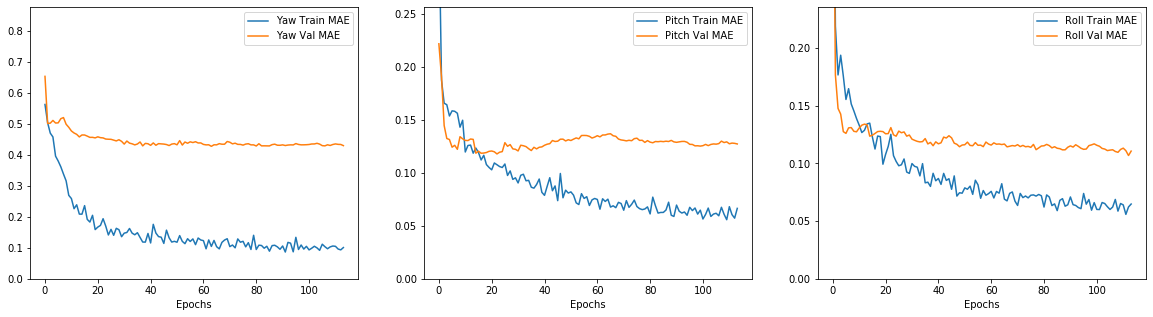

In [0]:
plot_training(history)